# RTS-96 results with new distributed slack

Start-to-finish RTS-96 results.

In [1]:
####### IMPORTS: DATA ACQUISITION ########
include("../src/tmp_inst_rts96.jl")

psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

####### IMPORTS: INSTANTON CODE ########
# Get instanton code into workspace:
include("../src/TemporalInstanton.jl")
include("../src/TrustRegionSubproblem.jl")

using TemporalInstanton, TrustRegionSubproblem

####### DATA LINKING ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
tau = 1. # Heating constant
G0 = [Gp,Gp.*0.95,Gp.*0.9]
D0 = [Dp,Dp.*0.95,Dp.*0.9]
P0 = [Rp,Rp,Rp]
kQobj = 0 # Should always be zero; objective has no constant term
c = 10. # RHS of line temperature constraint
kQtheta = -c # Move to LHS so we have Q(z) = 0

# Changing:
lines = [(f[i],t[i]) for i in 1:length(f)];

In [2]:
# For a single line:
line = lines[48]

# Create instance of instanton problem
Qobj,A,b,Qtheta = temporalInstanton(Ridx,Y,ref,k,tau,line,G0,P0,D0)

G_of_x = (Qobj,0,kQobj)
Q_of_x = (Qtheta,0,kQtheta)

T = int(length(G0)/size(Y,1))
part = size(A,2) - T

# Translate and rotate twice
H_of_x,R_of_x,x_star,A1,A2 = tr_translate(G_of_x,Q_of_x,A,b,Qtheta)
# R_of_x is rotation invariant.
J_of_z,Rkernel = tr_kernel_rotate(H_of_x,A)
K_of_w,Reigvec = tr_diag_rotate(J_of_z)

#H_of_x,J_of_z,K_of_w,R_of_x,x_star,Rkernel,Reigvec,A1,A2 = tr_trans_rotate(G_of_x,Q_of_x,A,b,Qtheta)

# Prepare to solve the secular equation:
#Qtheta = full(R_of_x[1])
Qtheta = Reigvec*Rkernel*full(R_of_x[1])*Rkernel'*Reigvec'
D = K_of_w[1]
d = K_of_w[2]./2
d2 = 0#Reigvec*Rkernel*R_of_x[2]
c = -R_of_x[3]

9.94338716014883

In [3]:
# Check 0 and diagonals of D before doing binary search
mu_vals,w_vals,check = tr_check_diag(D,d,d2,Qtheta,c)
# If all values of "check" are false, continue:
if all(!check)
# continue
else
display(mu_vals[find(check)])
end

# Solve secular equation:
solutions,vectors = tr_solve_secular(D,d,d2,Qtheta,c)

# Translate back to original variables:
xvec = tr_map_back(vectors[1],Rkernel,Reigvec,x_star)

T = int(length(G0)/size(Y,1))
deviations = Array(Vector{Float64},0)
angles = Array(Vector{Float64},0)
alpha = Float64[]
anglediffs = xvec[end-T+1:end]
n = size(Y,1)
nr = length(Ridx)

# Variable breakdown:
# (nr+n+1) per time step
#   First nr are deviations
#   Next n are angles
#   Last is mismatch
# T variables at the end: anglediffs
for t = 1:T
push!(deviations,xvec[(nr+n+1)*(t-1)+1:(nr+n+1)*(t-1)+nr])
push!(angles,xvec[(nr+n+1)*(t-1)+nr+1:(nr+n+1)*(t-1)+nr+n])
push!(alpha,xvec[(nr+n+1)*(t)])
end
[A*xvec-b]

LoadError: BoundsError()
while loading In[3], in expression starting on line 14

In [88]:
norm(diag(Reigvec)[end-2:end])

0.004585991407351062

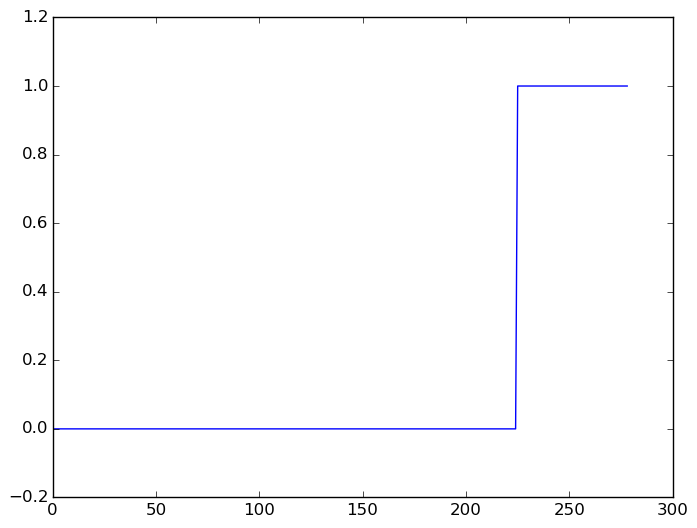

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f58448c8890>

In [68]:
plot(diag(D))

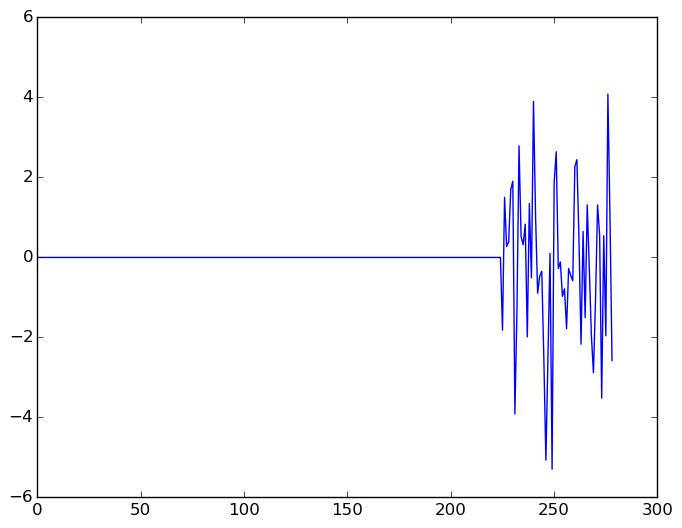

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f584479d150>

In [78]:
plot(vectors[1])

In [43]:
Reigvec*R_of_x[1]*Reigvec'

279x279 Array{Float64,2}:
  0.044393     -0.0165857    -0.013515     …  -0.000516051  -2.40951e-5 
 -0.0165857     0.00628687    0.00576848       0.00015308   -3.53473e-6 
 -0.013515      0.00576848    0.00984349      -0.000159344  -9.25402e-5 
  0.0283265    -0.0111184    -0.0128879       -9.37471e-5    5.89639e-5 
 -0.00104958    1.3024e-5    -0.00270066       0.000179026   5.32218e-5 
  0.00775127   -0.0028151    -0.00171561   …  -0.000125688  -1.54374e-5 
  0.0428616    -0.0169117    -0.0202034       -0.000103051   0.000101466
  0.00442517   -0.00238595   -0.00718394       0.00027096    9.93522e-5 
 -0.000498974   3.11301e-5   -0.00108523       7.41354e-5    2.18383e-5 
 -0.0141747     0.00529259    0.00428963       0.000166195   8.14159e-6 
 -0.000484275   0.000641219   0.00381433   …  -0.000196917  -6.36635e-5 
 -0.00738382    0.00317595    0.00557212      -9.77826e-5   -5.39441e-5 
 -0.0220999     0.0079058     0.00393214       0.00041134    6.07377e-5 
  ⋮                      

In [55]:
using PyPlot

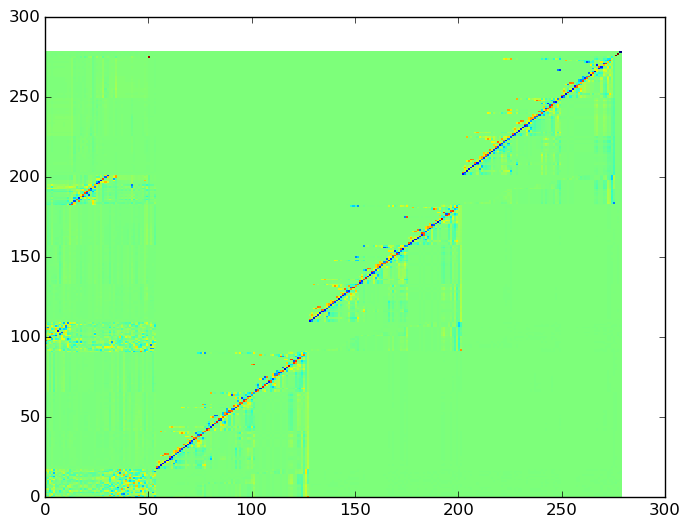

PyObject <matplotlib.collections.PolyCollection object at 0x7f5846feedd0>

In [65]:
pcolor(Rkernel)

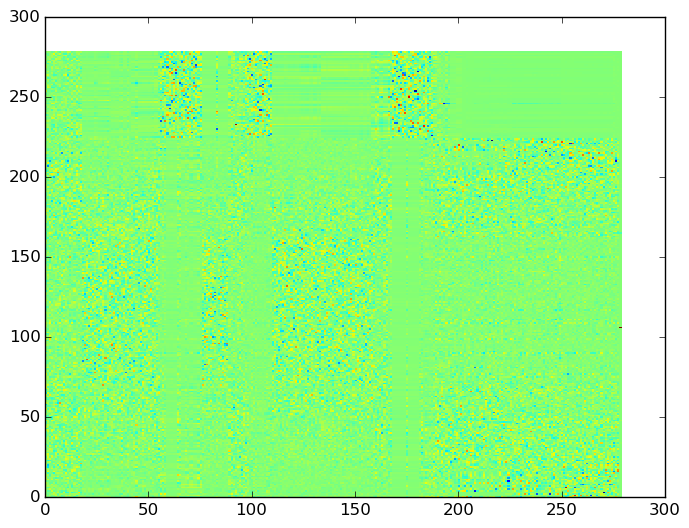

PyObject <matplotlib.collections.PolyCollection object at 0x7f58332482d0>

In [98]:
pcolor(Reigvec,vmax=0.6)

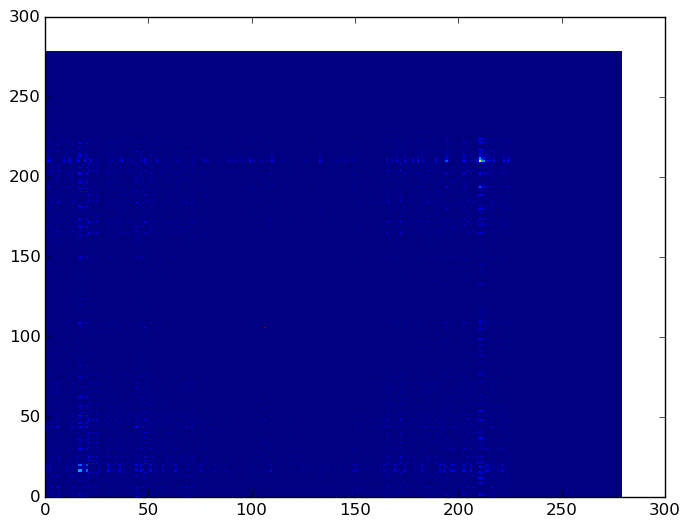

PyObject <matplotlib.collections.PolyCollection object at 0x7f58180a63d0>

In [125]:
pcolor((Reigvec*Qtheta*Reigvec'),vmin=-1e-6,vmax=0.4)

In [146]:
idx = find(abs(diag(Reigvec*Rkernel*Qtheta*Rkernel'*Reigvec')).>=sort(abs(diag(Reigvec*Rkernel*Qtheta*Rkernel'*Reigvec')))[end-2])
newQtheta = sort(abs(diag(Reigvec*Rkernel*Qtheta*Rkernel'*Reigvec')))#[end-2:end]

279-element Array{Float64,1}:
 2.40741e-35
 1.08334e-34
 3.43056e-34
 5.77779e-34
 6.92131e-34
 1.08334e-33
 1.21198e-33
 1.33611e-33
 1.59491e-33
 1.89132e-33
 1.97408e-33
 2.09445e-33
 2.43751e-33
 ⋮          
 0.0317258  
 0.0424539  
 0.0430868  
 0.044263   
 0.0504461  
 0.0520261  
 0.0733602  
 0.0862665  
 0.11148    
 0.117523   
 0.256376   
 0.99092    

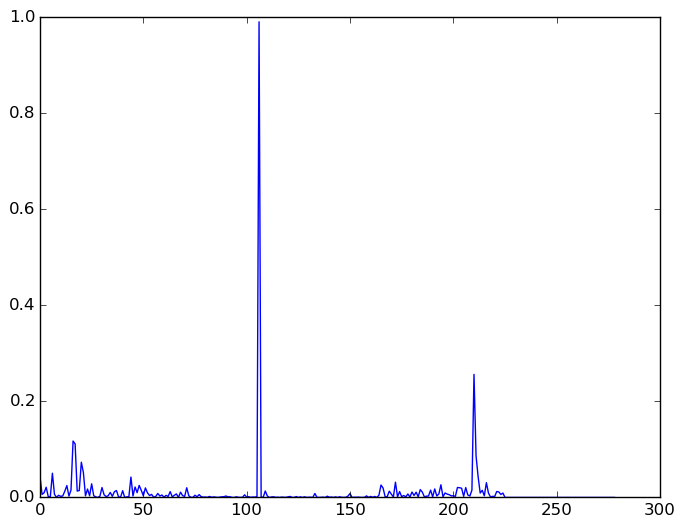

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f58129eac50>

In [155]:
plot(round(diag(Reigvec*Rkernel*Qtheta*Rkernel'*Reigvec'),5))

In [147]:
idx

3-element Array{Int64,1}:
  17
 107
 211

In [128]:
w = deepcopy(vectors[1])
w[107] = 5
wmap = Rkernel'*Reigvec'*w

279-element Array{Float64,1}:
  1.85692   
  1.73635   
  1.71528   
  1.7319    
  2.30345   
  2.00402   
  2.3469    
  2.01631   
  1.5168    
  2.23212   
  1.59149   
  2.31157   
  1.86238   
  ⋮         
  0.0342273 
 -0.00663923
  0.0731125 
 -0.0235851 
  0.024592  
 -0.0257691 
  0.0432879 
 -0.0461865 
 -0.0288337 
 -0.00957626
 -0.00898058
 -4.97723   

In [129]:
norm(wmap[end-2:end])

4.977248128011626

In [10]:
A2*xvec[end-2:end]

225-element Array{FloatingPoint,1}:
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  ⋮       
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
 -0.144441
 -0.137246
 -0.130051

In [11]:
b - A1*xvec[1:end-3]

225-element Array{FloatingPoint,1}:
 -1.28786e-14
  3.41869    
  4.19664e-14
 -3.77476e-14
 -1.7486e-14 
 -2.5091e-14 
  1.05471e-14
  4.16334e-15
  1.37668e-14
  7.61613e-14
 -1.75179e-13
 -2.02061e-14
  1.11244e-13
  ⋮          
 -1.87184e-13
 -4.66294e-15
  3.71925e-14
  2.15383e-13
 -3.9968e-14 
 -1.88294e-13
  2.4869e-14 
  1.06581e-13
  6.65981e-16
 -0.144441   
 -0.137246   
 -0.130051   

In [23]:
sumabs2((d./diag(D))[end-2:end])

8.749275140325052

In [76]:
norm(Qtheta*Reigvec'*vectors[1])

0.07091106569286247

In [75]:
c

4.943387160148831

In [17]:
(Rkernel*R_of_x[1]*Rkernel')[end-2:end,end-2:end]

3x3 Array{Float64,2}:
  0.99968      -3.3385e-19   -2.98248e-19
 -3.3385e-19    0.99968       1.29047e-18
 -2.98248e-19   1.29047e-18   0.99968    

In [4]:
alpha

3-element Array{Float64,1}:
 -2.06417
 -1.97214
 -1.88012

In [5]:
using PyPlot

INFO: Loading help data...


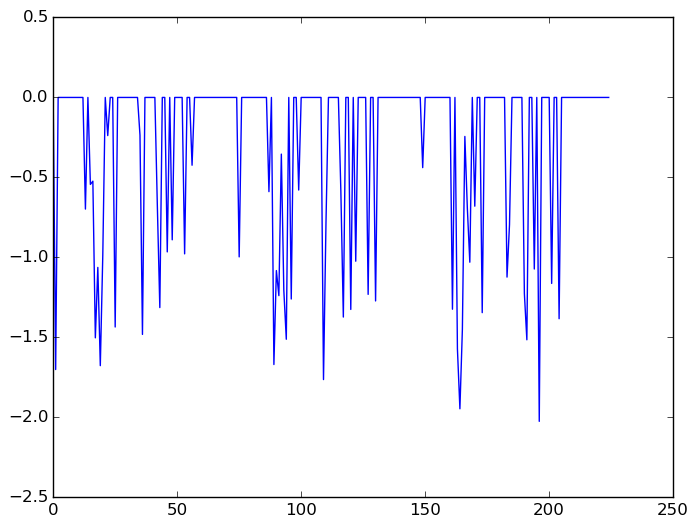

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fce488dcd90>

In [6]:
plot(A*xvec-b)

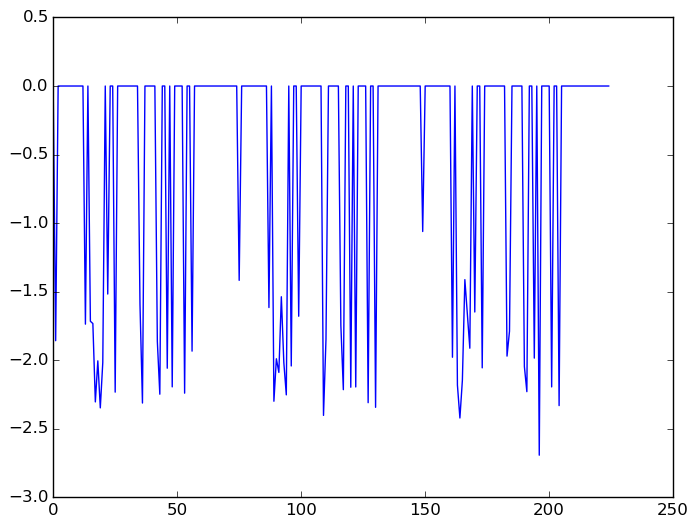

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdcb78f1d90>

In [10]:
plot(A*xvec-b)

In [12]:
vectors[1]

279-element Array{Float64,1}:
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  ⋮       
 -0.263174
 -1.94022 
 -2.88108 
 -1.09484 
  1.31121 
  0.561054
 -3.51584 
  0.540241
 -1.9572  
  4.08463 
  1.0525  
 -2.57781 

In [13]:
xvec

279-element Array{FloatingPoint,1}:
  0.620169 
 -0.136963 
 -0.252248 
 -0.275207 
  0.281728 
  0.0484629
  0.403906 
 -0.0161078
 -0.417756 
  0.255967 
 -0.449592 
  0.261259 
 -0.204286 
  ⋮        
  0.42993  
  0.34117  
  0.342982 
  0.454206 
  0.5491   
  0.352264 
  0.264833 
  0.341659 
 -1.88012  
 -0.144441 
 -0.137246 
 -0.130051 

In [18]:
x_star[73 + 18 + 1]

-2.0641700754571937

In [19]:
sumabs2(anglediffs)

0.056612839851170105

In [8]:
sum(Dp) - sum(Gp) - sum(Rp) - sum(deviations[1])

-37.9609694287125

In [10]:
sum(D0[1:length(Dp)] - G0[1:length(Gp)] - P0[1:length(Rp)]) - sum(deviations[1])

-37.9609694287125

$\alpha$ does not seem to be capturing the mismatch.

In [11]:
alpha

3-element Array{Float64,1}:
 -2.06417
 -1.97214
 -1.88012

Not getting any solutions. Let's plot the secular equation:

In [12]:
using Interact
using PyPlot

INFO: Loading help data...


Slider{Float64}([Input{Float64}] 25.0,"cval",25.0,20.0:0.5:30.0)

[]

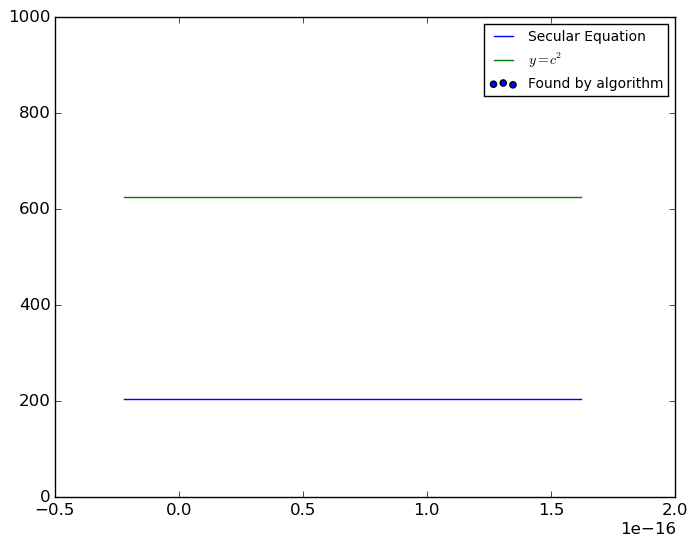

In [20]:

poles = [D[i,i]*Qtheta[i,i] for i in setdiff(1:size(D,1),find(round(diag(Qtheta),10).==0))]
mu_vals = linspace(0.5*minimum(poles),1.5*maximum(poles),1000)

fig = figure()
@manipulate for cval = 20:0.5:30; withfig(fig) do
        solutions,vectors = tr_solve_secular(D,d,d2,Qtheta,cval)
        print(solutions)
        s_vals = [sumabs2(find_w(mu,D,d,d2,Qtheta)) for mu in mu_vals]
        plot(mu_vals,s_vals)
        hold = true
        plot([mu_vals[1],mu_vals[end]],[cval^2,cval^2])
        ylim([0,1000]) #ylim([0,2*c^2])
        xlim = [mu_vals[1],mu_vals[end]]
        scatter(solutions,cval^2*ones(length(solutions)))
        legend(["Secular Equation",L"y = c^2","Found by algorithm"],fontsize=10)
    end
end

In [26]:
poles = [D[i,i]*Qtheta[i,i] for i in setdiff(1:size(D,1),find(round(diag(Qtheta),10).==0))]

225-element Array{Any,1}:
 -3.65906e-17
 -5.18729e-18
 -7.26119e-18
 -1.56207e-17
 -1.13858e-18
 -9.3164e-19 
 -3.27013e-17
 -3.97587e-18
 -1.63024e-19
 -2.61224e-18
 -1.24253e-18
 -1.56926e-18
 -6.21545e-18
  ⋮          
  4.65962e-18
  7.77205e-18
  1.86447e-18
  1.76823e-17
  5.52231e-18
  5.04712e-19
  1.43036e-18
  1.23602e-18
  8.70703e-18
  8.5857e-18 
  5.1789e-18 
  8.11467e-18

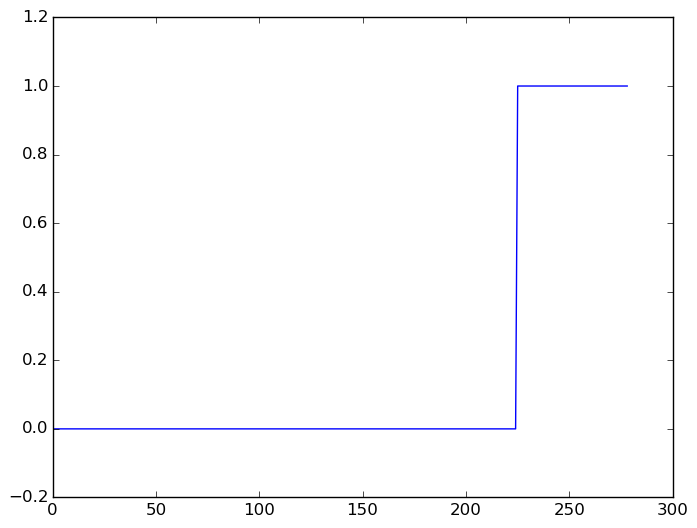

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92307b1190>

In [29]:
plot(diag(D))

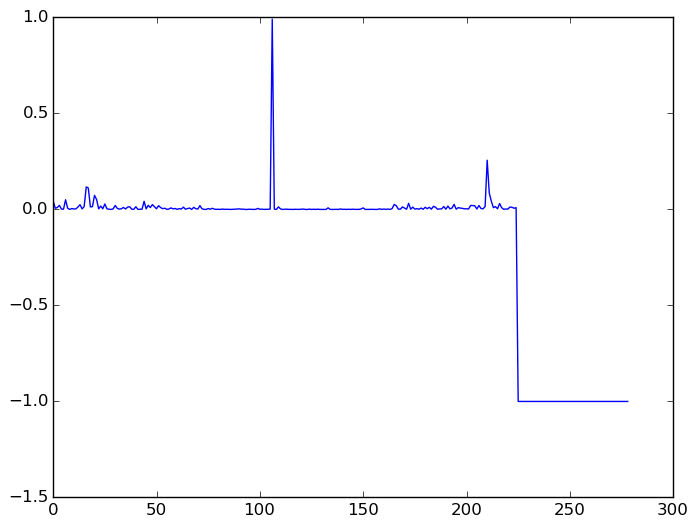

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9230687ed0>

In [31]:
plot(diag(Qtheta) - diag(D))

In [35]:
w = find_w(1,D,d,d2,round(Qtheta,10))

279-element Array{Float64,1}:
 -0.0     
 -0.0     
 -0.0     
 -0.0     
 -0.0     
  0.0     
 -0.0     
  0.0     
  0.0     
 -0.0     
  0.0     
 -0.0     
 -0.0     
  ⋮       
 -0.263174
 -1.94022 
 -2.88108 
 -1.09484 
  1.31121 
  0.561054
 -3.51584 
  0.540241
 -1.9572  
  2.44407 
  0.629771
 -1.54246 

In [36]:
w'*Qtheta*w

1-element Array{Float64,1}:
 8.88161e-30

In [40]:
denom = [1*Qtheta[i,i] - round(D,10)[i,i] for i in 1:length(d)]

279-element Array{Any,1}:
  0.044263   
  0.00632553 
  0.00985849 
  0.0212714  
  0.00158166 
  0.00141871 
  0.0504461  
  0.00650527 
  0.000272825
  0.00453996 
  0.0023181  
  0.00304777 
  0.0129295  
  ⋮          
 -1.0        
 -1.0        
 -1.0        
 -1.0        
 -1.0        
 -1.0        
 -1.0        
 -1.0        
 -1.0        
 -1.0        
 -1.0        
 -1.0        

In [60]:
d2 = zeros(length(d))
mu = 50
wtest = zeros(length(d))
for i in setdiff(1:length(d),find(denom.==0.0))
    wtest[i] = float( (round(d,10)[i] - mu*d2[i])/denom[i] )
end
wtest

279-element Array{Float64,1}:
 -0.0     
 -0.0     
 -0.0     
 -0.0     
 -0.0     
  0.0     
 -0.0     
  0.0     
  0.0     
 -0.0     
  0.0     
 -0.0     
 -0.0     
  ⋮       
 -0.263174
 -1.94022 
 -2.88108 
 -1.09484 
  1.31121 
  0.561054
 -3.51584 
  0.540241
 -1.9572  
  2.44407 
  0.629771
 -1.54246 

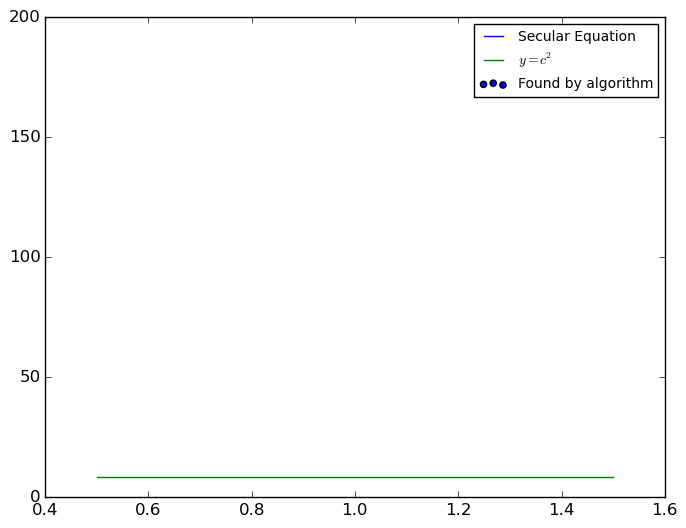

PyObject <matplotlib.legend.Legend object at 0x7ff0a84b0c10>

In [21]:
        solutions,vectors = tr_solve_secular(D,d,d2,Qtheta,c)

        s_vals = [sumabs2(find_w(mu,D,d,d2,Qtheta)) for mu in mu_vals]
        plot(mu_vals,s_vals)
        hold = true
        plot([mu_vals[1],mu_vals[end]],[c^2,c^2])
        ylim([0,200]) #ylim([0,2*c^2])
        xlim = [mu_vals[1],mu_vals[end]]
        scatter(solutions,c^2*ones(length(solutions)))
        legend(["Secular Equation",L"y = c^2","Found by algorithm"],fontsize=10)